In [1]:
# 모듈 import

from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

In [2]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')

root='../dataset/'

# dataset config 수정
cfg.data.train.classes = classes
cfg.data.train.img_prefix = root
cfg.data.train.ann_file = '/opt/ml/detection/dataset/trn_val_split_json/train_split_0.json' # train json 정보
cfg.data.train.pipeline[2]['img_scale'] = (1024,1024) # Resize

cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json' # test json 정보
cfg.data.test.pipeline[1]['img_scale'] = (1024,1024) # Resize

cfg.data.samples_per_gpu = 4

cfg.seed = 2021
cfg.gpu_ids = [0]
cfg.work_dir = './work_dirs/faster_rcnn_r50_fpn_1x_trash'

cfg.model.roi_head.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.checkpoint_config = dict(max_keep_ckpts=3, interval=1)

기본 저장되어있는 데이터 파이프라인은 다음과 같습니다.

In [3]:
cfg.data.train.pipeline = \
[{'type': 'LoadImageFromFile'},
 {'type': 'LoadAnnotations', 'with_bbox': True},
 {'type': 'Resize', 'img_scale': (1024, 1024), 'keep_ratio': True},
 {'type': 'RandomFlip', 'flip_ratio': 0.5},
 {'type': 'Normalize',
  'mean': [123.675, 116.28, 103.53],
  'std': [58.395, 57.12, 57.375],
  'to_rgb': True},
 {'type': 'Pad', 'size_divisor': 32},
 {'type': 'DefaultFormatBundle'},
 {'type': 'Collect', 'keys': ['img', 'gt_bboxes', 'gt_labels']}]

내가 적용한 어그멘테이션을 바꾸고 싶다면 아래에서 추가한 후에 바꾸면 됩니다.

In [4]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
albu_train_transforms = [
    dict(type='HorizontalFlip',p=0.3),
    dict(
        type="OneOf",
        transforms=[
            dict(type="HueSaturationValue", hue_shift_limit=10, sat_shift_limit=35, val_shift_limit=25),
            dict(type="RandomGamma"),
            dict(type="CLAHE"),
        ],
        p=0.5,
    ),
    dict(
        type="OneOf",
        transforms=[
            dict(type="Blur"),
            dict(type="MotionBlur"),
            dict(type="GaussNoise"),
        ],
        p=0.4,
    ),
    dict(
        type="OneOf",
        transforms=[
            dict(type="RandomToneCurve", scale=2.),
            dict(type='RandomBrightnessContrast',brightness_limit=[-0.2, 0.2],contrast_limit=[-0.2, 0.2]),
        ],
        p=0.4,
    ),
    dict(type='RGBShift', p = 0.2)
]


cfg.data.train.pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1024, 1024), keep_ratio=True),
    dict(type='Pad', size_divisor=32),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Albu',
        transforms=albu_train_transforms,
        bbox_params=dict(
            type='BboxParams',
            format='pascal_voc',
            label_fields=['gt_labels'],
            min_visibility=0.0,
            filter_lost_elements=True),
        keymap={
            'img': 'image',
            # 'gt_masks': 'masks',
            'gt_bboxes': 'bboxes'
        },
        update_pad_shape=False,
        skip_img_without_anno=True),
    dict(type='Normalize', **img_norm_cfg),
  #  dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]


In [5]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import cv2

def inverse_normalize(tensor, mean=[123.675, 116.28, 103.53], std= [58.395, 57.12, 57.375]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


train_coco = COCO(cfg.data.train.ann_file)
mmdet_dataset = build_dataset(cfg.data.train)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [6]:
category_map = {0: 'General trash',1: 'Paper',2: 'Paper pack',3: 'Metal',4: 'Glass',
 5: 'Plastic',6: 'Styrofoam',7: 'Plastic bag',8: 'Battery',9: 'Clothing'}

color_dict = {0:(0,0,255), 1:(0,50,255), 2:(0,255,255), 3:(0,255,100), 4:(0,255,0), 
5:(100,255,0), 6:(255,0,0), 7:(255,5,0), 8:(255,0,100), 9:(255,255,255)}

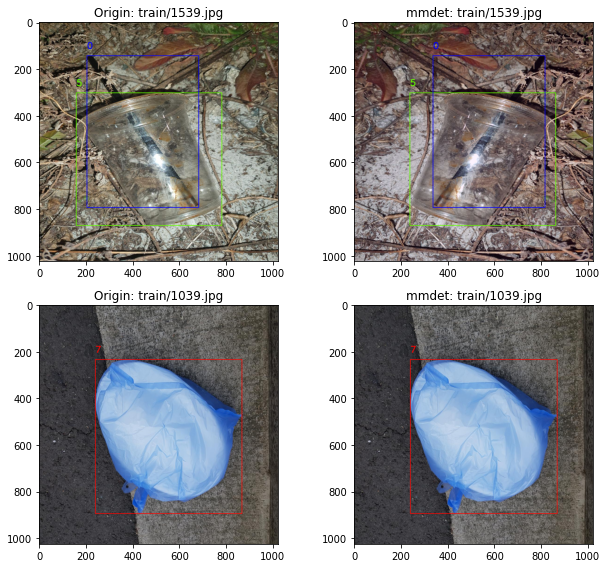

In [7]:
#plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
# ax = ax.flatten()

for i, idx in enumerate(random.sample(range(0, len(mmdet_dataset)), 2)):

    # origin
    image_id = train_coco.getImgIds(imgIds=idx)
    image_info = train_coco.loadImgs(image_id)[0]

    ann_ids = train_coco.getAnnIds(imgIds=image_info['id'])
    anns = train_coco.loadAnns(ann_ids)
    boxes = np.array([x['bbox'] for x in anns])
    labels = [x['category_id'] for x in anns]

    img = cv2.imread('../dataset/'+image_info['file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for category, bbox in zip(labels, boxes):
        color = color_dict[category]
        x,y, w, h = bbox
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.rectangle(img, (int(x),int(y)), (int(x)+int(w),int(y)+int(h)), color, 2) 
        cv2.putText(img, str(category), (int(x),int(y)-30), font, 1.3, color, 2)

    ax[i, 0].imshow(img)
    ax[i, 0].set_title("Origin: " + image_info['file_name'])

    ## mmdetection 

    mmdet_container = mmdet_dataset.prepare_train_img(idx)
#    mmdet_data_path = mmdet_container['img_metas'].data['filename']
    mmdet_img_array = inverse_normalize(mmdet_container['img'].data).numpy().transpose(1, 2, 0).astype(np.uint8).copy()
    mmdet_bboxs = mmdet_container['gt_bboxes'].data.numpy().astype(int)
    mmdet_labels = mmdet_container['gt_labels'].data.numpy()
    
    for category, bbox in zip(mmdet_labels, mmdet_bboxs):
        color = color_dict[category]
        xmin,ymin, xmax, hmax = bbox
#        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.rectangle(mmdet_img_array, (int(xmin),int(ymin)), (int(xmax),int(hmax)), color, 2) 
        cv2.putText(mmdet_img_array, str(category), (int(xmin),int(ymin)-30), font, 1.3, color, 2)

    ax[i, 1].imshow(mmdet_img_array)
    ax[i, 1].set_title("mmdet: " + image_info['file_name'])


plt.tight_layout()
plt.show()

## Mosaic

In [100]:
# dataset settings
dataset_type = 'CocoDataset'
data_root = '/opt/ml/detection/dataset/'
classes = ['General trash','Paper','Paper pack','Metal','Glass','Plastic',
'Styrofoam','Plastic bag','Battery','Clothing']

img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)


albu_train_transforms = [
    dict(type='HorizontalFlip',p=0.3),
    dict(
        type="OneOf",
        transforms=[
            dict(type="HueSaturationValue", hue_shift_limit=10, sat_shift_limit=35, val_shift_limit=25),
            dict(type="RandomGamma"),
            # dict(type="CLAHE"),
        ],
        p=0.5,
    ),
    dict(
        type="OneOf",
        transforms=[
            dict(type="Blur"),
            dict(type="MotionBlur"),
            dict(type="GaussNoise"),
        ],
        p=0.4,
    ),
    dict(
        type="OneOf",
        transforms=[
            dict(type="RandomToneCurve", scale=2.),
            dict(type='RandomBrightnessContrast',brightness_limit=[-0.2, 0.2],contrast_limit=[-0.2, 0.2]),
        ],
        p=0.4,
    ),
    dict(type='RGBShift', p = 0.2)
]


train_pipeline = [
   # dict(type='Mosaic', img_scale=(640, 640), center_ratio_range=(1, 1), pad_val=114.0),
    dict(
        type='Albu',
        transforms=albu_train_transforms,
        bbox_params=dict(
            type='BboxParams',
            format='pascal_voc',
            label_fields=['gt_labels'],
            min_visibility=0.0,
            filter_lost_elements=True),
        keymap={
            'img': 'image',
            # 'gt_masks': 'masks',
            'gt_bboxes': 'bboxes'
        },
        update_pad_shape=False,
        skip_img_without_anno=True),
    dict(type='MixUp',img_scale=(1024, 1024),ratio_range=(0.8, 1.2),pad_val=114.0, p=0.5),
    dict(type='Resize', img_scale=(1024, 1024), keep_ratio=True),
    dict(type='Pad', size_divisor=32),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]

# test_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(
#         type='MultiScaleFlipAug',
#         img_scale=(1024, 1024),  
#         flip=False,
#         transforms=[
#             dict(type='Resize', keep_ratio=True),
#             dict(type='RandomFlip'),
#             dict(type='Normalize', **img_norm_cfg),
#             dict(type='Pad', size_divisor=32),
#             dict(type='ImageToTensor', keys=['img']),
#             dict(type='Collect', keys=['img']),
#         ])
# ]

data = dict(
    samples_per_gpu=16, # batch size
    workers_per_gpu=2, # data loader
    # type='MultiImageMixDataset',
    train=dict(
        type='MultiImageMixDataset',# type=dataset_type,
        dataset =dict(
        type = dataset_type,
        ann_file=data_root + "trn_val_split_json/train_split_0.json",#'trn_val_split_json/train_split_0.json',
        img_prefix=data_root,
        pipeline= [
                dict(type='LoadImageFromFile', to_float32=False),
                dict(type='LoadAnnotations', with_bbox=True)
            ],
        classes = classes,
        ),
    pipeline=train_pipeline
    )
)


In [101]:
cfg.data = data

In [102]:
cfg.data

{'samples_per_gpu': 16,
 'workers_per_gpu': 2,
 'train': {'type': 'MultiImageMixDataset',
  'dataset': {'type': 'CocoDataset',
   'ann_file': '/opt/ml/detection/dataset/trn_val_split_json/train_split_0.json',
   'img_prefix': '/opt/ml/detection/dataset/',
   'pipeline': [{'type': 'LoadImageFromFile', 'to_float32': False},
    {'type': 'LoadAnnotations', 'with_bbox': True}],
   'classes': ['General trash',
    'Paper',
    'Paper pack',
    'Metal',
    'Glass',
    'Plastic',
    'Styrofoam',
    'Plastic bag',
    'Battery',
    'Clothing']},
  'pipeline': [{'type': 'Albu',
    'transforms': [{'type': 'HorizontalFlip', 'p': 0.3},
     {'type': 'OneOf',
      'transforms': [{'type': 'HueSaturationValue',
        'hue_shift_limit': 10,
        'sat_shift_limit': 35,
        'val_shift_limit': 25},
       {'type': 'RandomGamma'}],
      'p': 0.5},
     {'type': 'OneOf',
      'transforms': [{'type': 'Blur'},
       {'type': 'MotionBlur'},
       {'type': 'GaussNoise'}],
      'p': 0.4},


In [103]:
mmdet_dataset = build_dataset(cfg.data.train)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [104]:
import pandas as pd
with open(data_root + "trn_val_split_json/train_split_0.json") as f:
    train = json.load(f)
origin_img_df = pd.json_normalize(train['images'])

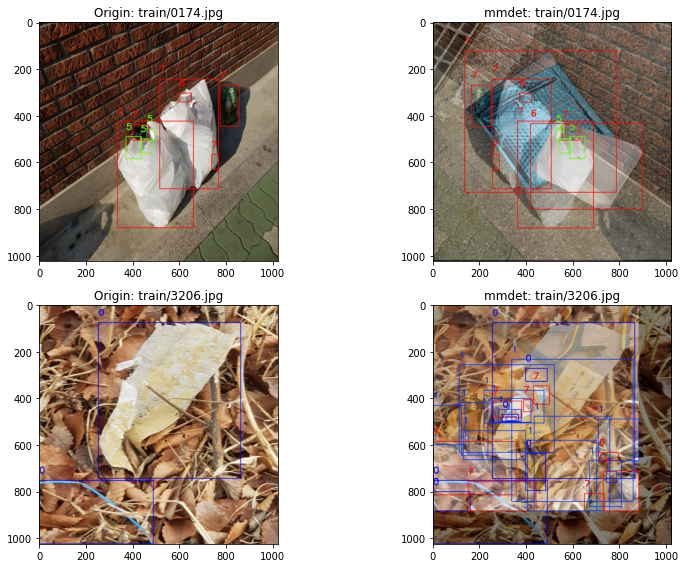

In [107]:
#plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
# ax = ax.flatten()

for i, idx in enumerate(random.sample(range(0, len(mmdet_dataset)), 2)):
    mmdet_filenmae = mmdet_dataset[idx]['img_metas'].data['ori_filename']
    origin_img_id = origin_img_df.loc[origin_img_df['file_name'] == mmdet_filenmae, 'id'].iloc[0]
    # origin
    image_id = train_coco.getImgIds(imgIds=origin_img_id)
    image_info = train_coco.loadImgs(image_id)[0]

    ann_ids = train_coco.getAnnIds(imgIds=image_info['id'])
    anns = train_coco.loadAnns(ann_ids)
    boxes = np.array([x['bbox'] for x in anns])
    labels = [x['category_id'] for x in anns]

    img = cv2.imread('../dataset/'+image_info['file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for category, bbox in zip(labels, boxes):
        color = color_dict[category]
        x,y, w, h = bbox
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.rectangle(img, (int(x),int(y)), (int(x)+int(w),int(y)+int(h)), color, 2) 
        cv2.putText(img, str(category), (int(x),int(y)-30), font, 1.3, color, 2)

    ax[i, 0].imshow(img)
    ax[i, 0].set_title("Origin: " + image_info['file_name'])

    ## mmdetection 

    mmdet_container = mmdet_dataset[idx]
#    mmdet_data_path = mmdet_container['img_metas'].data['filename']
    mmdet_img_array = inverse_normalize(mmdet_container['img'].data).numpy().transpose(1, 2, 0).astype(np.uint8).copy()
    mmdet_bboxs = mmdet_container['gt_bboxes'].data.numpy().astype(int)
    mmdet_labels = mmdet_container['gt_labels'].data.numpy()
    
    for category, bbox in zip(mmdet_labels, mmdet_bboxs):
        color = color_dict[category]
        xmin ,ymin, xmax, ymax = bbox
#        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.rectangle(mmdet_img_array, (int(xmin),int(ymin)), (int(xmax),int(ymax)), color, 2) 
        cv2.putText(mmdet_img_array, str(category), (int(xmin),int(ymin)-30), font, 1.3, color, 2)

    ax[i, 1].imshow(mmdet_img_array)
    ax[i, 1].set_title("mmdet: " + mmdet_dataset[idx]['img_metas'].data['ori_filename'])


plt.tight_layout()
plt.show()

In [ ]:
mmdet_bboxs

array([[   0,  731,   36,  806],
       [  35,  583,  528,  629],
       [ 208,  515,  419,  629],
       [  34,  606,  532,  925],
       [ 459,  612,  497,  673],
       [   0,  798,   82,  991],
       [   0,  915,   32, 1023],
       [ 451,  583,  500,  610],
       [ 204,  642,  380,  748],
       [ 397,  472, 1024,  659],
       [ 281,  695,  967,  887],
       [   0,    0,  829,  177]])

In [132]:
# # 모델 build 및 pretrained network 불러오기
# model = build_detector(cfg.model)
# model.init_weights()

In [133]:
# # 모델 학습
# train_detector(model, datasets[0], cfg, distributed=False, validate=False)